In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch===1.2.0 torchvision===0.4.0

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -q -U watermark

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -qq transformers

Note: you may need to restart the kernel to use updated packages.


In [5]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.7.6
IPython 7.12.0

numpy 1.18.1
pandas 1.0.1
torch 1.2.0
transformers 2.9.1


In [6]:
pip install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [7]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
df = pd.read_csv("reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOGt2KEhc-yNMmOBsXqfHKLGJ-vDENQPVPlGZIM...,Earl Clark,https://lh3.googleusercontent.com/a-/AOh14Gj_X...,"This is an expensive app. That being said, it'...",1,28,5.0.0.11,2020-05-16 17:23:38,We are not aware of any issues with editing ta...,2020-05-17 12:06:29,most_relevant,com.anydo
1,gp:AOqpTOFnIu5LAl0bREEIRnyqUs95zFeDP4kQ-eY638E...,Elad Posner,https://lh3.googleusercontent.com/a-/AOh14Ghzk...,Something is wrong with the last version. Sinc...,1,80,5.0.0.11,2020-05-08 13:48:18,Sorry about that. Please uninstall and reinsta...,2020-05-10 11:25:36,most_relevant,com.anydo
2,gp:AOqpTOE4go3obyJs27PrDvsA_mPKmlYD_muUNj3NHNA...,Checaii Garcia,https://lh3.googleusercontent.com/a-/AOh14GiQ8...,I wanted to try the app but it never opens. I ...,1,23,5.0.0.11,2020-05-08 10:26:34,Sorry about that! Please feel free to contact ...,2020-05-10 11:20:14,most_relevant,com.anydo
3,gp:AOqpTOF3Kb-6IdEeeYLcuUncmzjQdtNguLU5GTshqNY...,A Traveller,https://lh3.googleusercontent.com/-yutN8c-KH6U...,This app is a prime example of building a moun...,1,14,5.0.0.11,2020-05-09 19:20:56,If you're having trouble figuring out how to t...,2020-05-12 10:22:05,most_relevant,com.anydo
4,gp:AOqpTOEcQLSS_guCIsZflL1BJmk6h6WHCVNSFO_OI1N...,Kenneth Ho,https://lh3.googleusercontent.com/a-/AOh14GitU...,I have been using it since 2018 and am current...,1,12,5.0.0.11,2020-05-08 21:56:31,"Hi, please note that we detected a slight issu...",2020-05-10 11:57:17,most_relevant,com.anydo


In [9]:
df = df.drop('reviewId', axis=1)

In [10]:
df.shape

(15880, 11)

In [11]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Earl Clark,https://lh3.googleusercontent.com/a-/AOh14Gj_X...,"This is an expensive app. That being said, it'...",1,28,5.0.0.11,2020-05-16 17:23:38,We are not aware of any issues with editing ta...,2020-05-17 12:06:29,most_relevant,com.anydo
1,Elad Posner,https://lh3.googleusercontent.com/a-/AOh14Ghzk...,Something is wrong with the last version. Sinc...,1,80,5.0.0.11,2020-05-08 13:48:18,Sorry about that. Please uninstall and reinsta...,2020-05-10 11:25:36,most_relevant,com.anydo
2,Checaii Garcia,https://lh3.googleusercontent.com/a-/AOh14GiQ8...,I wanted to try the app but it never opens. I ...,1,23,5.0.0.11,2020-05-08 10:26:34,Sorry about that! Please feel free to contact ...,2020-05-10 11:20:14,most_relevant,com.anydo
3,A Traveller,https://lh3.googleusercontent.com/-yutN8c-KH6U...,This app is a prime example of building a moun...,1,14,5.0.0.11,2020-05-09 19:20:56,If you're having trouble figuring out how to t...,2020-05-12 10:22:05,most_relevant,com.anydo
4,Kenneth Ho,https://lh3.googleusercontent.com/a-/AOh14GitU...,I have been using it since 2018 and am current...,1,12,5.0.0.11,2020-05-08 21:56:31,"Hi, please note that we detected a slight issu...",2020-05-10 11:57:17,most_relevant,com.anydo


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15880 entries, 0 to 15879
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15880 non-null  object
 1   userImage             15880 non-null  object
 2   content               15880 non-null  object
 3   score                 15880 non-null  int64 
 4   thumbsUpCount         15880 non-null  int64 
 5   reviewCreatedVersion  13676 non-null  object
 6   at                    15880 non-null  object
 7   replyContent          8031 non-null   object
 8   repliedAt             8031 non-null   object
 9   sortOrder             15880 non-null  object
 10  appId                 15880 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


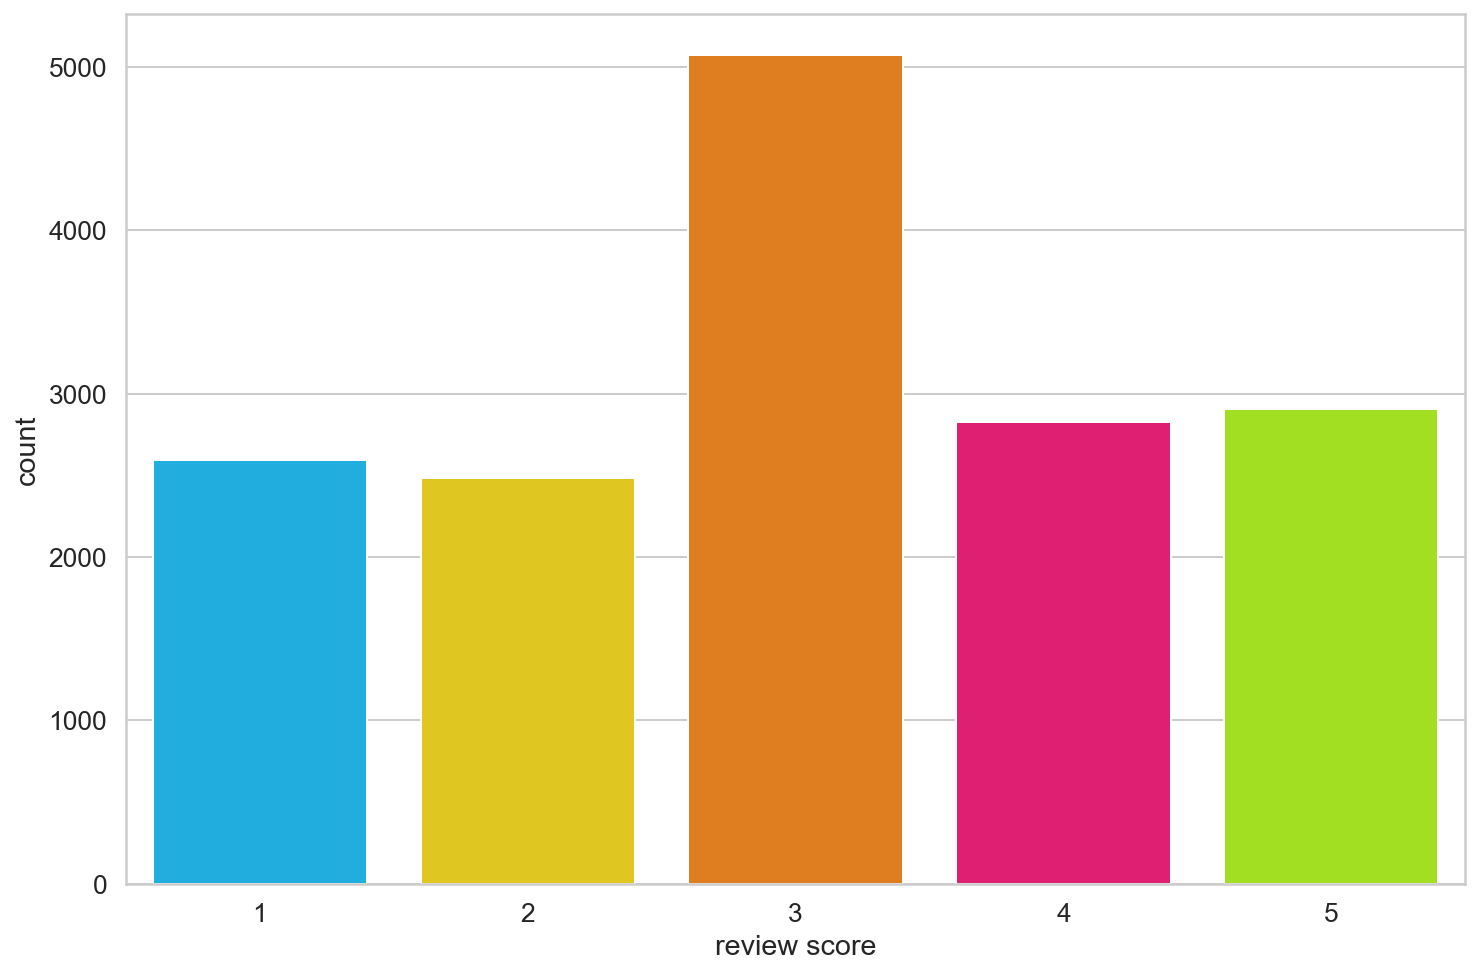

In [13]:
sns.countplot(df.score)
plt.xlabel('review score');

In [14]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [15]:
class_names = ['negative', 'neutral', 'positive']

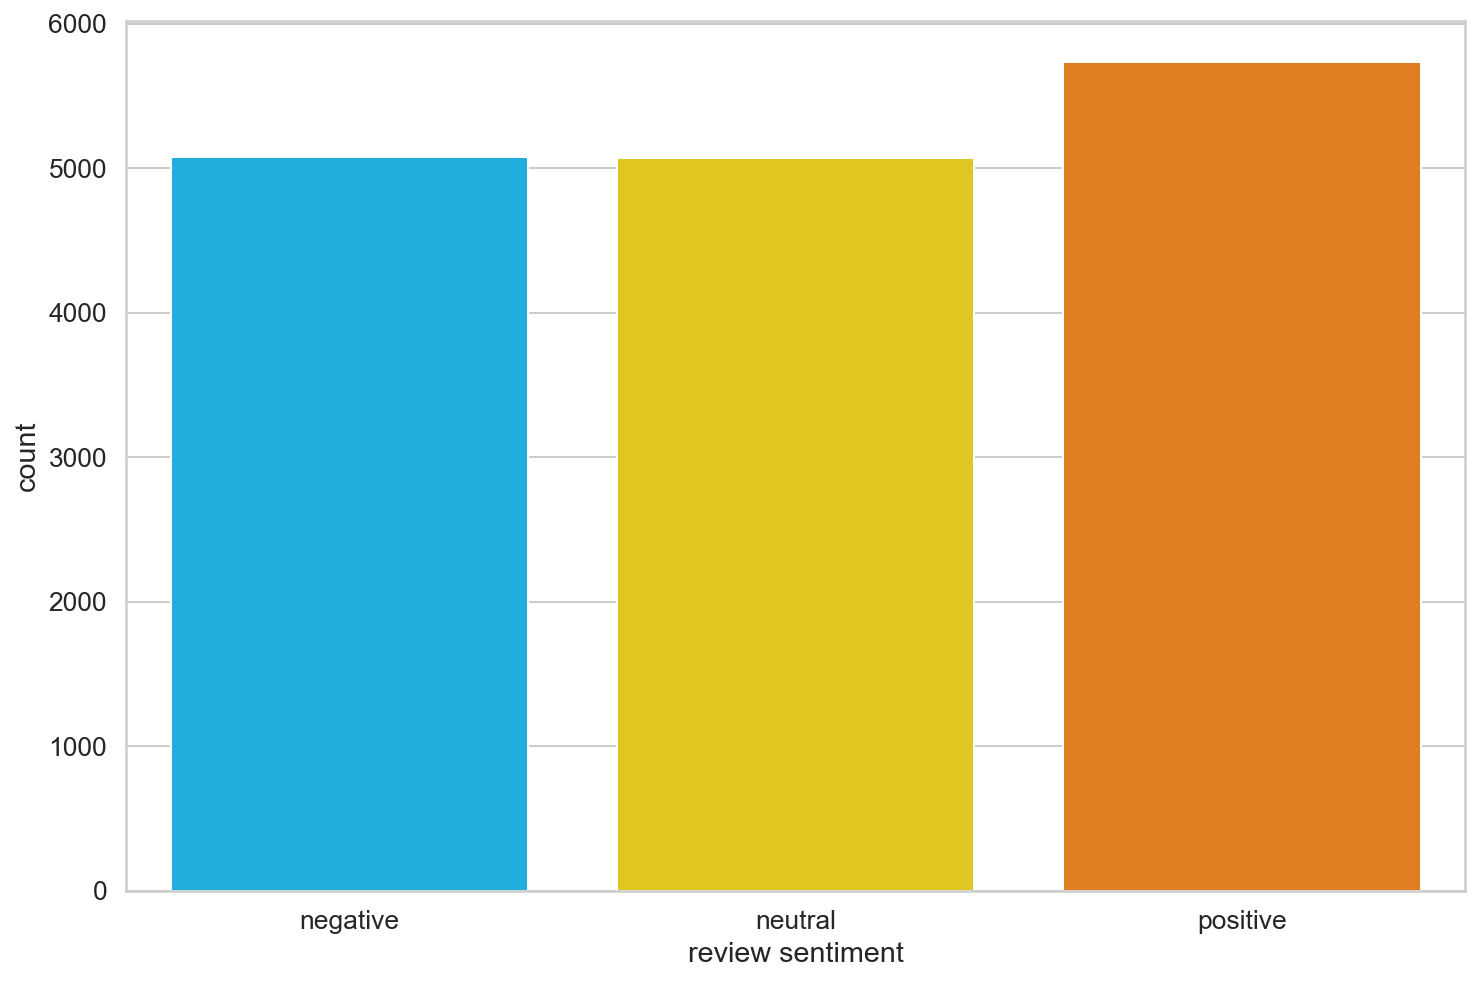

In [16]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [17]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [18]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [19]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [20]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [21]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [22]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [23]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [24]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [25]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [26]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [27]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [28]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [29]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

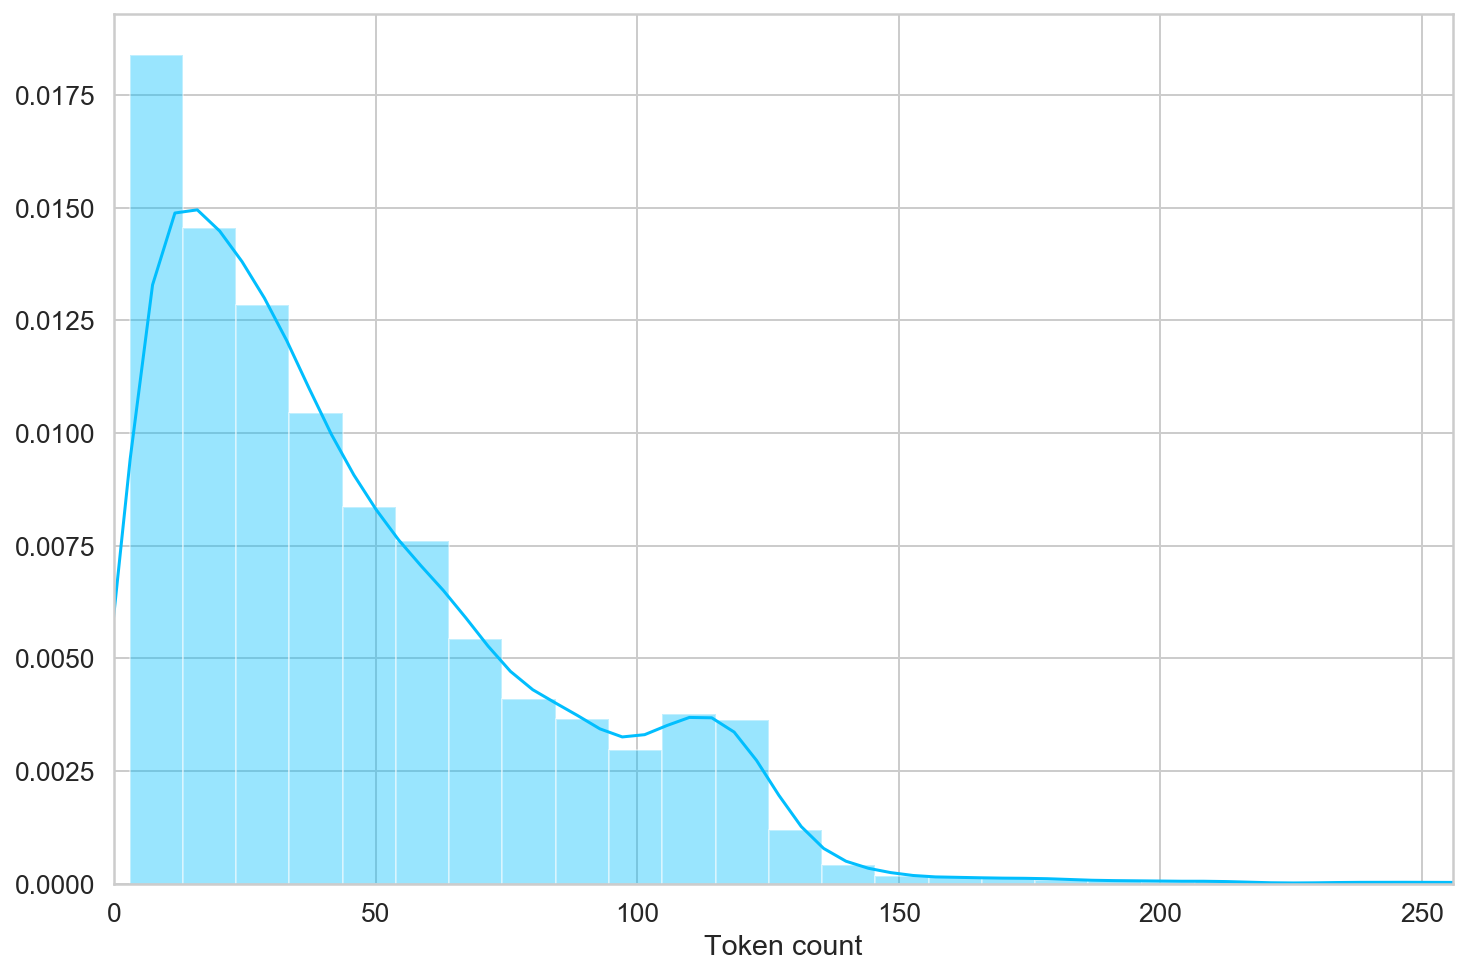

In [30]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [31]:
MAX_LEN = 160

In [32]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [33]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [34]:
df_train.shape, df_val.shape, df_test.shape

((14292, 12), (794, 12), (794, 12))

In [46]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [47]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [48]:
data = next(iter(train_data_loader))
data.keys()

BrokenPipeError: [Errno 32] Broken pipe